# Análise exploratória de Dados IMDB

## A Análise deve ser capaz de responder a seguintes perguntas: 
- [Quais são as categorias de filmes mais comuns no IMDB?](#categorias)
- [Qual o número de títulos por gênero?](#numero-titulos)
- [Qual a mediana de avaliação dos filmes por gênero?](#mediana-genero)
- [Qual a mediana de avaliação dos filmes em relação ao ano de estréia?](#mediana-anos)
- [Qual o número de filmes avaliados por gênero em relação ao ano de estréia?](#avaliação-genero)
- [Qual o filme com maior tempo de duração? Calcule os percentis.](#tempo)
- [Qual a relação entre duração e gênero?](#duraçãoxgenero)
- [Qual o número de filmes produzidos por país?](#filmes-pais)
- [Quais são os top 10 melhores filmes?](#top-10-filmes)
- [Quais são os top 10 piores filmes?](#top-10-piores-filmes)

# Instalando e Carregando Pacotes

In [1]:
# instalando os pacotes
# pacote do IMDB no SQLite
! pip install -q imdb-sqlite
# pacote para acessar dados ISO de paises 
! pip install -q pycountry

In [2]:
# importando bibliotecas 
import re 
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm 
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style= 'whitegrid')

# Carregando os Dados

In [3]:
%%time 
!imdb-sqlite

Wall time: 687 ms


2021-09-16 10:36:47,087 DB already exists: (imdb.db). Refusing to modify. Exiting


In [4]:
# conectar no banco de dados 
conn = sqlite3.connect('imdb.db')

In [5]:
# extrair linha das tabelas 
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM sqlite_master WHERE type = 'table'", conn)

In [6]:
type(tabelas)

pandas.core.frame.DataFrame

In [7]:
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [8]:
# Converter o dataframe em lista
tabelas  = tabelas['Table_Name'].values.tolist()

In [9]:
tabelas

['people', 'titles', 'akas', 'crew', 'episodes', 'ratings']

In [10]:
# Percorrer a lista de tabelas e extrair o esquema de cada uma 
for tabela in tabelas:
    consulta = 'PRAGMA TABLE_INFO({})'.format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print('Esquema da tabela: ', tabela)
    display(resultado)
    print('-' * 100)
    print()

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------

Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------



# Quais são as categorias de filmes mais comuns no IMDB? <a class="anchor" id="categorias"></a>

In [11]:
# criar a consulta SQL
consulta1 = '''SELECT type, COUNT(*) AS COUNT FROM titles GROUP BY type'''

In [12]:
# extrair o resultado 
resultado1 = pd.read_sql_query(consulta1, conn)

In [13]:
display(resultado1)

,type,COUNT
0,movie,586667
1,radioEpisode,1
2,radioSeries,1
3,short,828806
4,tvEpisode,6032701
5,tvMiniSeries,39562
6,tvMovie,132787
7,tvPilot,1
8,tvSeries,213899
9,tvShort,10249


In [14]:
# calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [15]:
display(resultado1)

,type,COUNT,percentual
0,movie,586667,7.130343
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,828806,10.073297
4,tvEpisode,6032701,73.321367
5,tvMiniSeries,39562,0.480836
6,tvMovie,132787,1.613891
7,tvPilot,1,0.000012
8,tvSeries,213899,2.599726
9,tvShort,10249,0.124566


In [16]:
# Criar um grafico com apenas 4 categorias
# # categorias com mais Títulos e 1 com todos os outros 

# criar um dicionario vazio
others = {}

# filtrar o percentual em 5% e soma o tatal 
others['COUNT'] = resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# gravar o percentual 
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# ajustar o nome
others['type'] = 'others'

In [17]:
others

{'COUNT': 779579, 'percentual': 9.474992747108477, 'type': 'others'}

In [18]:
# filtrar o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [19]:
# append com o dataframe de outras categorias
resultado1 = resultado1.append(others, ignore_index = True)

In [20]:
# ordenar o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending= False)

In [21]:
resultado1.head() 

,type,COUNT,percentual
2,tvEpisode,6032701,73.321367
1,short,828806,10.073297
3,others,779579,9.474993
0,movie,586667,7.130343


In [22]:
# ajustar labels 
labels = [str(resultado1['type'][i])+ ' '+'['+ str(round(resultado1['percentual'][i], 2)) + '%' + ']' for i in resultado1.index]

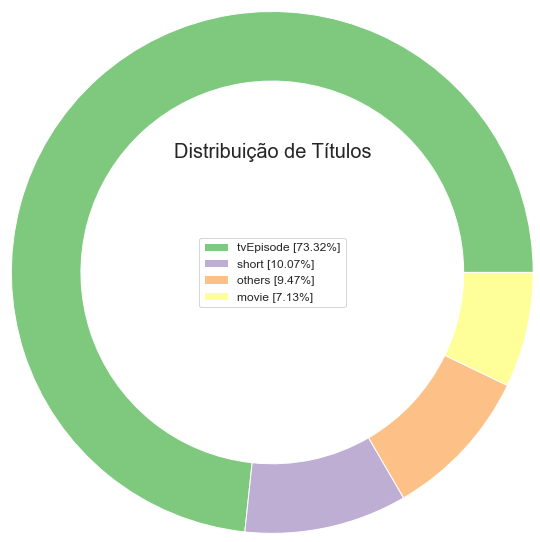

In [23]:
# plot grafico

# mapa de cores
cs = cm.Accent(np.arange(100))

# criar figura
f = plt.figure()

# pie plot (grafico de pizza)
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops=dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title('Distribuição de Títulos', loc = 'Center', fontdict = {'fontsize':20, 'fontsize':20})
plt.show()

# Qual o número de títulos por gênero?<a class="anchor" id="numero-titulos"></a>

In [24]:
# criar a consulta SQL 
consulta2 = '''SELECT genres, COUNT(*) FROM titles WHERE type = 'movie' GROUP BY genres'''

In [25]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [26]:
display(resultado2)

,genres,COUNT(*)
0,Action,13385
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1442,"Thriller,Western",39
1443,War,1253
1444,"War,Western",9
1445,Western,4012


In [27]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [28]:
temp = resultado2['genres'].dropna()

In [29]:
display(resultado2)

,genres,COUNT(*)
0,action,13385
1,"action,adult",11
2,"action,adult,adventure",1
3,"action,adult,comedy",5
4,"action,adult,crime",10
...,...,...
1442,"thriller,western",39
1443,war,1253
1444,"war,western",9
1445,western,4012


In [30]:
# criar vetor usando expressão regular para filtar as strings 
padrao = '(?u)\\b[\\w-]+\\b'
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [31]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [32]:
# aplicar a vetorização ao dataset sem valores NA
bag_genres = vetor.transform(temp)

In [33]:
type(bag_genres)

scipy.sparse.csr.csr_matrix

In [34]:
# retorna gêneros ùnicos
generos_unicos = vetor.get_feature_names()

In [35]:
# cria o dataframe de gêneros
generos = pd.DataFrame(bag_genres.todense(), columns = generos_unicos, index = temp.index)

In [36]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1447 entries, 0 to 1446
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1447 non-null   int64
 1   adult        1447 non-null   int64
 2   adventure    1447 non-null   int64
 3   animation    1447 non-null   int64
 4   biography    1447 non-null   int64
 5   comedy       1447 non-null   int64
 6   crime        1447 non-null   int64
 7   documentary  1447 non-null   int64
 8   drama        1447 non-null   int64
 9   family       1447 non-null   int64
 10  fantasy      1447 non-null   int64
 11  film-noir    1447 non-null   int64
 12  game-show    1447 non-null   int64
 13  history      1447 non-null   int64
 14  horror       1447 non-null   int64
 15  music        1447 non-null   int64
 16  musical      1447 non-null   int64
 17  mystery      1447 non-null   int64
 18  n            1447 non-null   int64
 19  news         1447 non-null   int64
 20  reality-

In [37]:
generos = generos.drop(columns = 'n', axis = 0)

In [38]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
generos_percentual.head(10)

drama          18.382861
comedy         16.931583
documentary    15.964064
adventure      14.858328
action         14.651002
romance        13.476158
crime          12.992398
mystery        12.577747
thriller       12.370422
fantasy        12.232205
dtype: float64

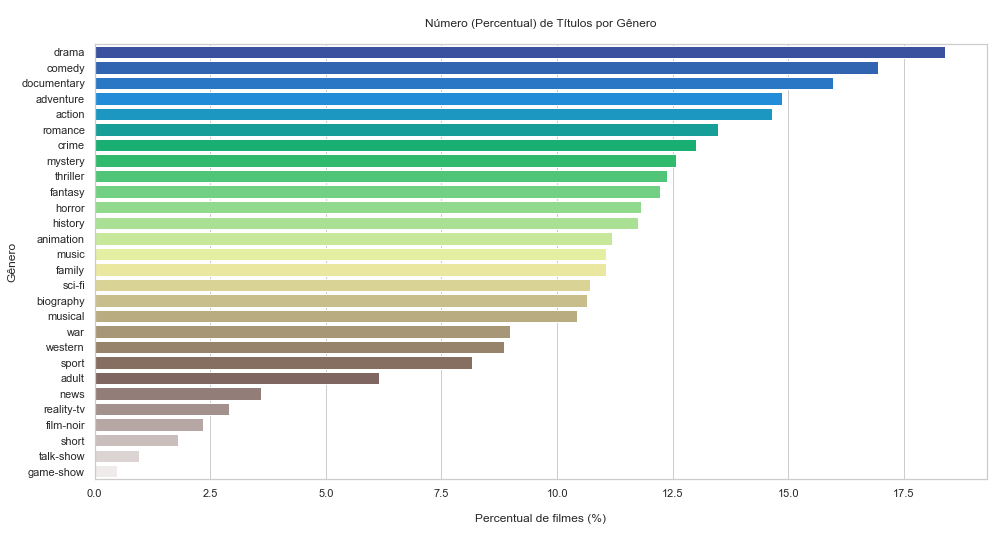

In [40]:
# plot 
plt.figure(figsize = (16, 8))
sns.barplot(x = generos_percentual.values, 
            y = generos_percentual.index, 
            orient = 'h', palette = 'terrain')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de filmes (%)\n')
plt.title('\nNúmero (Percentual) de Títulos por Gênero\n')
plt.show()

# Qual a mediana de avaliação dos filmes por gênero?  <a class="anchor" id="mediana-genero"></a>

In [41]:
consulta3 = '''
            SELECT rating, genres FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie' 
            '''

In [42]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
display(resultado3)

,rating,genres
0,4.5,\N
1,6.1,"Action,Adventure,Biography"
2,5.2,Drama
3,4.5,Drama
4,3.8,Drama
...,...,...
267851,3.5,"Action,Adventure,Thriller"
267852,5.8,Thriller
267853,6.3,"Adventure,Drama,History"
267854,3.8,"Adventure,History,War"


In [44]:
# criar uma função para retonrar os gêneros
def retorna_genero(df):
    df['genres'] = df['genres'].str.lower().values
    temp = df['genres'].dropna()
    vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
    generos_unicos = vetor.get_feature_names()
    generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
    return generos_unicos

In [45]:
generos_unicos = retorna_genero(resultado3)

In [46]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [47]:
genero_counts = []
genero_ratings = []

for item in generos_unicos:
    # retorna a contagem de filmes por gênero
    consulta = 'SELECT COUNT(rating) FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_counts.append(resultado.values[0][0])
    
    # retorna a avaliação de filmes por gênero
    consulta = 'SELECT rating FROM ratings JOIN titles ON ratings.title_id=titles.title_id WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_ratings.append(np.median(resultado['rating']))

In [48]:
# Dataframe final
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [49]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,28802,5.80
1,adult,4076,5.80
2,adventure,17685,6.00
3,animation,4676,6.45
4,biography,8054,7.00
5,comedy,66779,6.00
6,crime,23070,6.10
7,documentary,39246,7.30
8,drama,118905,6.30
9,family,10174,6.30


In [50]:
# drop informação indesejada
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [51]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

In [52]:
df_genero_ratings.head(20)

,genres,count,rating
7,documentary,39246,7.30
22,short,19,7.20
12,game-show,3,7.20
4,biography,8054,7.00
13,history,7367,6.90
24,talk-show,10,6.75
23,sport,3164,6.70
26,war,5799,6.60
11,film-noir,760,6.60
15,music,12354,6.60


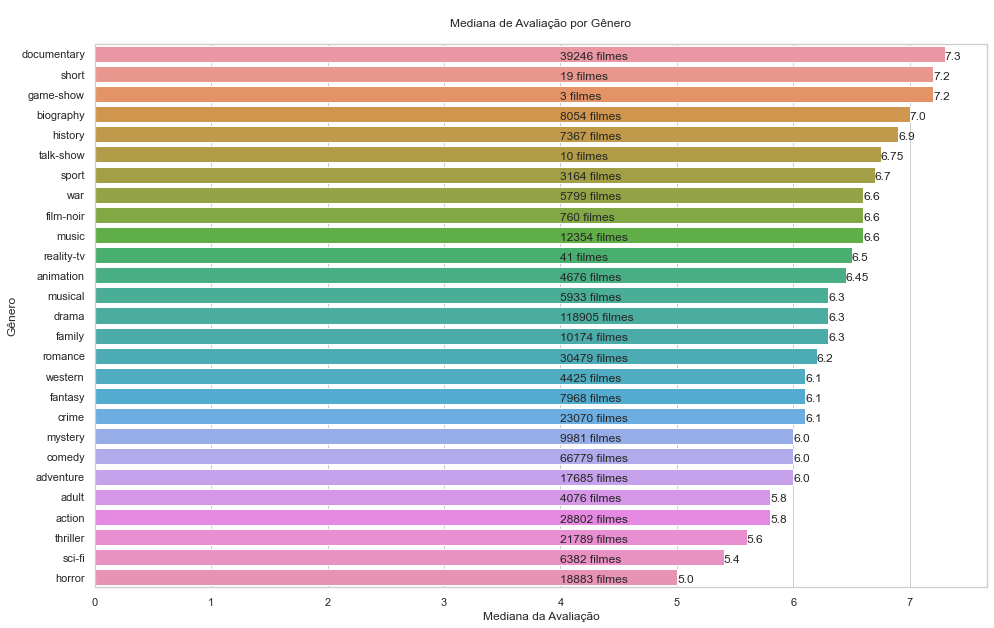

In [53]:
plt.figure(figsize = (16, 10))

sns.barplot(y = df_genero_ratings.genres, 
            x = df_genero_ratings.rating, 
            orient = "h")

for i in range(len(df_genero_ratings.index)):
    plt.text(4.0,
             i + 0.25, 
            str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + " filmes")
    plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
            i + 0.25, 
            round(df_genero_ratings['rating'][df_genero_ratings.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação por Gênero\n')
plt.show()

# Qual a mediana de avaliação dos filmes em relação ao ano de estréia? <a class="anchor" id="mediana-anos">

In [54]:
consulta4 = '''
            SELECT rating AS Rating,premiered FROM 
            ratings JOIN titles ON ratings.title_id = titles.title_id 
            WHERE premiered <= 2022 AND type = 'movie'
            ORDER BY premiered
            '''
resultado4 = pd.read_sql_query(consulta4, conn)
display(resultado4)

,Rating,premiered
0,6.4,1896
1,4.4,1897
2,3.9,1899
3,3.7,1899
4,6.0,1900
...,...,...
267851,4.8,2021
267852,9.8,2021
267853,8.3,2021
267854,6.0,2021


In [55]:
# Calculamos a mediana ao longo do tempo (anos) 
ratings = []
for year in set(resultado4['premiered']):
    ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [56]:
type(ratings)

list

In [57]:
ratings[1:10]

[4.4, 3.8, 6.15, 4.5, 3.5, 4.6, 5.4, 4.5, 3.6]

In [58]:
anos = list(set(resultado4['premiered']))

In [59]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

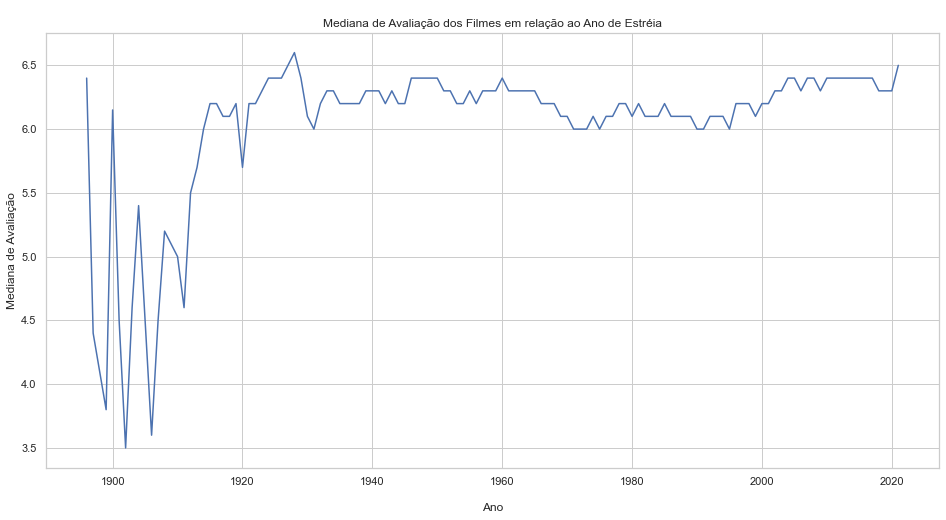

In [60]:
plt.figure(figsize = (16, 8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes em relação ao Ano de Estréia')
plt.show()

# Qual o número de filmes avaliados por gênero em relação ao ano de estréia <a class="anchor" id="avaliação-genero">

In [61]:
consulta5 = '''
            SELECT genres FROM titles
            '''
resultado5 = pd.read_sql_query(consulta5, conn)
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
8227748,"Action,Drama,Family"
8227749,"Action,Drama,Family"
8227750,"Action,Drama,Family"
8227751,Short


In [62]:
generos_unicos = retorna_genero(resultado5)

In [63]:
#contando
genero_count = []
for i in generos_unicos:
    consulta = 'SELECT COUNT(*) COUNT FROM  titles WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND premiered <= 2022'
    resultado = pd.read_sql_query(consulta, conn)
    genero_count.append(resultado['COUNT'].values[0])

In [64]:
# Dataframes
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_counts

In [65]:
#top 5 
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

In [66]:
top_generos

array(['drama', 'comedy', 'documentary', 'romance', 'action'],
      dtype=object)

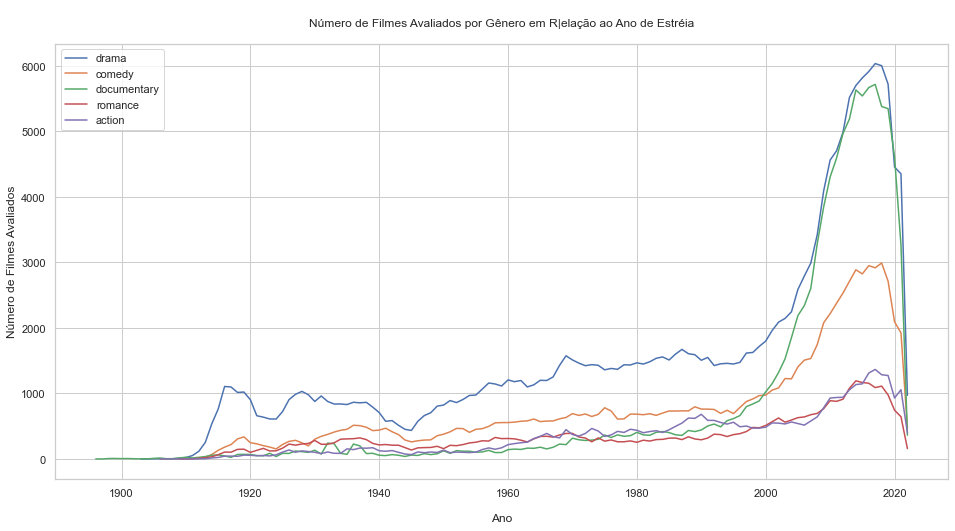

In [67]:
plt.figure(figsize = (16, 8))

for item in top_generos:
    consulta = 'SELECT COUNT(*) Number_of_movies, premiered Year FROM titles WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Year <= 2022 GROUP BY Year'
    resultado = pd.read_sql_query(consulta, conn)
    plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados por Gênero em R|elação ao Ano de Estréia\n')
plt.legend(labels = top_generos)
plt.show()

# Qual o Filme Com Maior Tempo de Duração <a class="anchor" id="tempo">

In [68]:
consulta6 = '''
            SELECT runtime_minutes Runtime 
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            '''
resultado6 = pd.read_sql_query(consulta6, conn)
display(resultado6)

,Runtime
0,100
1,70
2,90
3,120
4,58
...,...
369348,123
369349,57
369350,100
369351,116


In [69]:
# Loop para cálculo dos percentis
for i in range(101): 
    val = i
    perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
    print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 48.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 52.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 54.0
8 percentil da duração (runtime) é: 55.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 58.0
11 percentil da duração (runtime) é: 59.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 62.0
16 percentil da duração (runtime) é: 63.0
17 percentil da duração (runtime) é: 65.0
18 percentil da duração (runtime) é: 66.0
19 percentil da duração (runtime) é: 68.0
20 percentil da duração (runtime) é: 70.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 71.0
23 percentil da duração (runtime) é: 72.0
24 

In [70]:
consulta6 = '''
            SELECT runtime_minutes Runtime, primary_title
            FROM titles 
            WHERE type = 'movie' AND Runtime != 'NaN'
            ORDER BY Runtime DESC
            LIMIT 1
            '''
resultado6 = pd.read_sql_query(consulta6, conn)

In [71]:
resultado6

,Runtime,primary_title
0,51420,Logistics


'Logistics' é o filme mais longo da história (até este momento), com 857 horas (51420 minutos). Dirigido por Daniel Andersson e Erika Magnusson, o filme acompanha todo o ciclo de vida de um pedômetro (dispositivo de rastreamento de passos) em ordem cronológica reversa.

# Qual a relação entre duração e gênero?<a class="anchor" id="duraçãoxgenero">

In [77]:
consulta7 = '''
            SELECT AVG(runtime_minutes) Runtime, genres 
            FROM titles 
            WHERE type = 'movie'
            AND runtime_minutes != 'NaN'
            GROUP BY genres
            '''
resultado7 = pd.read_sql_query(consulta7, conn)
generos_unicos = retorna_genero(resultado7)

In [78]:
genero_runtime = []
for item in generos_unicos:
    consulta = 'SELECT runtime_minutes Runtime FROM  titles  WHERE genres LIKE '+ '\''+'%'+item+'%'+'\' AND type=\'movie\' AND Runtime!=\'NaN\''
    resultado = pd.read_sql_query(consulta, conn)
    genero_runtime.append(np.median(resultado['Runtime']))

In [79]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime
# Remove índice 18 (news)
df_genero_runtime = df_genero_runtime.drop(index = 18)
df_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

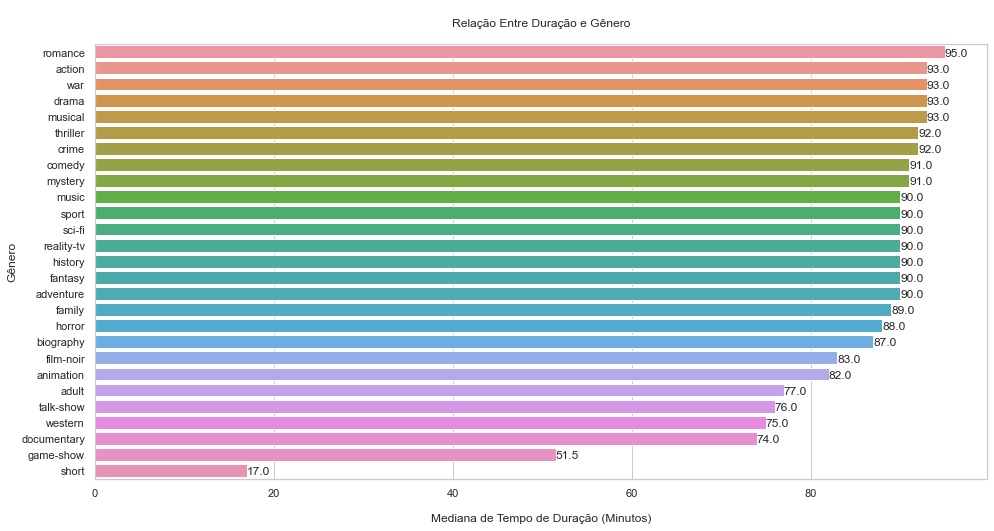

In [80]:
# Plot
plt.figure(figsize = (16,8))
sns.barplot(y = df_genero_runtime.genre, x = df_genero_runtime.runtime, orient = "h")

for i in range(len(df_genero_runtime.index)):
    plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
             i + 0.25,
             round(df_genero_runtime["runtime"][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')             
plt.xlabel('\nMediana de Tempo de Duração (Minutos)')
plt.title('\nRelação Entre Duração e Gênero\n')
plt.show()

# Qual o número de filmes produzidos por país?
<a class="anchor" id="filmes-pais">

In [81]:
consulta8 = '''
            SELECT region, COUNT(*) Number_of_movies FROM 
            akas JOIN titles ON 
            akas.title_id = titles.title_id
            WHERE region != 'None'
            AND type = \'movie\'
            GROUP BY region
            '''
resultado8 = pd.read_sql_query(consulta8, conn)
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,462
2,AF,109
3,AG,12
4,AL,1234
...,...,...
229,YUCS,146
230,ZA,3038
231,ZM,11
232,ZRCD,2


In [82]:
resultado8.shape

(234, 2)

In [83]:
# Listas auxiliares
nomes_paises = []
contagem = []

In [84]:
for i in range(resultado8.shape[0]):
    try:
        coun = resultado8['region'].values[i]
        nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
        contagem.append(resultado8['Number_of_movies'].values[i])
    except: 
        continue

In [85]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem
# Ordena o resultado
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [86]:
df_filmes_paises.head(10)

,country,Movie_Count
199,United States,294532
65,United Kingdom,149899
96,Japan,88708
63,France,81690
89,India,73677
32,Canada,69877
47,Germany,66480
93,Italy,63583
26,Brazil,62527
58,Spain,62254


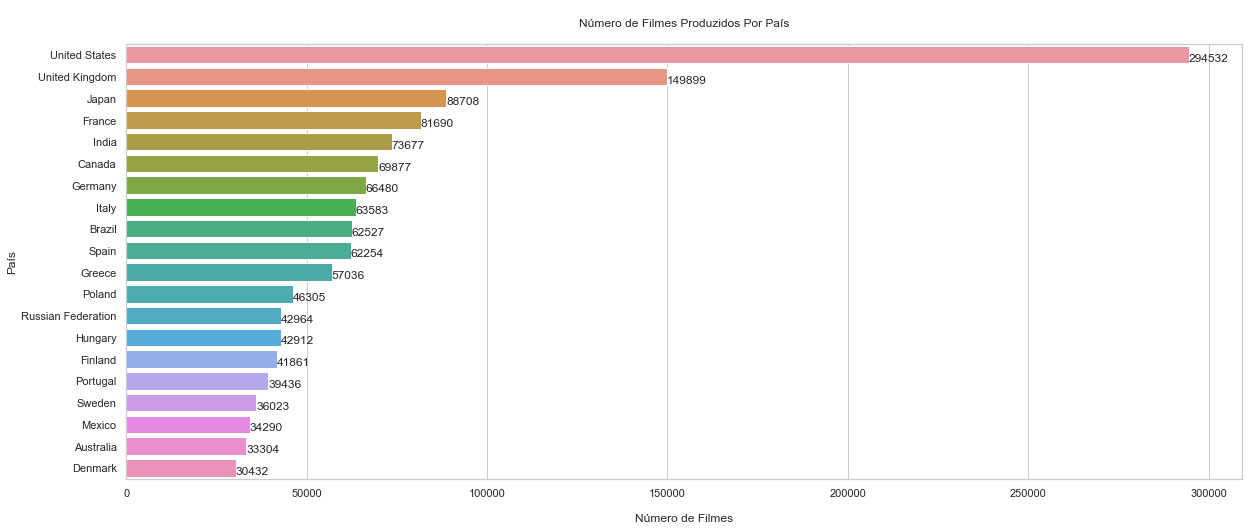

In [87]:
# Plot
plt.figure(figsize = (20,8))
sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = "h")

for i in range(0,20):
    plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]]-1,
             i + 0.30,
             round(df_filmes_paises["Movie_Count"][df_filmes_paises.index[i]],2))

plt.ylabel('País')             
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos Por País\n')
plt.show()

# Quais são os top 10 melhores filmes?
<a class="anchor" id="top-10-filmes">

In [88]:
consulta9 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating DESC
            LIMIT 10          
            '''
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Chaos Class,"Comedy,Drama",9.3
2,The Godfather,"Crime,Drama",9.2
3,CM101MMXI Fundamentals,"Comedy,Documentary",9.2
4,Soorarai Pottru,Drama,9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather: Part II,"Crime,Drama",9.0
7,The Dark Knight,"Action,Crime,Drama",9.0
8,David Attenborough: A Life on Our Planet,"Biography,Documentary",9.0
9,Schindler's List,"Biography,Drama,History",8.9


 # Quais São os Top 10 Piores Filmes <a class="anchor" id="top-10-piores-filmes">

In [89]:
consulta10 = '''
            SELECT primary_title AS Movie_Name, genres, rating
            FROM 
            titles JOIN ratings
            ON  titles.title_id = ratings.title_id
            WHERE titles.type = 'movie' AND ratings.votes >= 25000
            ORDER BY rating ASC
            LIMIT 10
            '''
top10_piores_filmes = pd.read_sql_query(consulta10, conn)
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Cumali Ceber,Comedy,1.0
1,Smolensk,"Drama,Thriller",1.1
2,Sadak 2,"Action,Drama",1.1
3,Reis,"Biography,Drama",1.4
4,Justin Bieber: Never Say Never,"Documentary,Music",1.6
5,Manos: The Hands of Fate,"Drama,Horror",1.8
6,Radhe,"Action,Crime,Thriller",1.8
7,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.9
8,The Hottie & the Nottie,"Comedy,Romance",1.9
9,Disaster Movie,"Comedy,Sci-Fi",1.9


## Fim